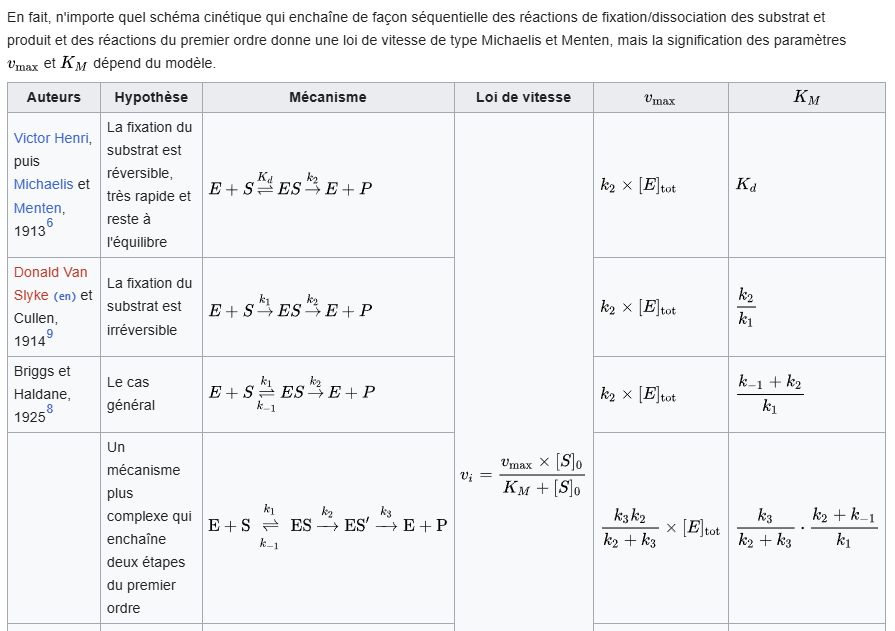

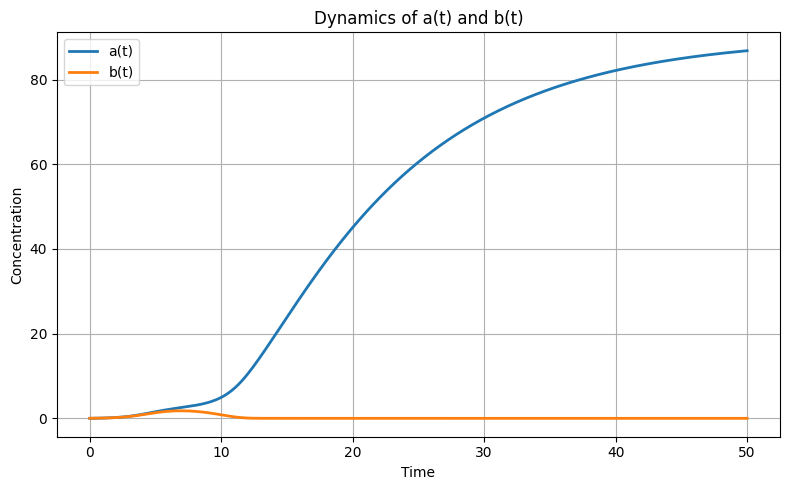

In [11]:
#!/usr/bin/env python3
"""
simulate_ab_constants.py

Integrates:
    da/dt = P + λ a/(1 + kα a) − η a − μ a b
    db/dt = N + λ̃ b/(1 + kβ b) − η b − μ a b

where P = ∑ w_{p,i} x_{p,i} and N = ∑ w_{n,j} x_{n,j} are fixed constants.
"""

import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

# === FIXED INPUTS AND WEIGHTS ===
# (edit these four constants as needed)
x_p = [1.0, 0.3]      # x_{p,1}, x_{p,2}
w_p = [0.025, 0.008]      # w_{p,1}, w_{p,2}

x_n = [0.8, 0.5]      # x_{n,1}, x_{n,2}
w_n = [0.025, 0.008]      # w_{n,1}, w_{n,2}

# Precompute the constant source terms P and N:
P = w_p[0]*x_p[0] + w_p[1]*x_p[1]
N = w_n[0]*x_n[0] + w_n[1]*x_n[1]

# === KINETIC PARAMETERS ===
lambda_a = 1.0    # λ
k_alpha  = 0.1    # k_α
lambda_b = 1.0    # λ̃
k_beta   = 0.1    # k_β
eta      = 0.1    # η
mu       = 0.3   # μ

# === ODE SYSTEM ===
def odes(t, y):
    a, b = y
    da = P + (lambda_a * a) / (1 + k_alpha * a) - eta * a - mu * a * b
    db = N + (lambda_b * b) / (1 + k_beta * b) - eta * b - mu * a * b
    return [da, db]

# === INITIAL CONDITIONS & TIME GRID ===
y0     = [0.01, 0.01]               # [a(0), b(0)]
t_span = (0.0, 50.0)              # time interval
t_eval = np.linspace(*t_span, 1000)

# === INTEGRATION ===
sol = solve_ivp(
    odes,
    t_span,
    y0,
    t_eval=t_eval,
    method='RK45',
    rtol=1e-6,
    atol=1e-9
)

# === PLOTTING ===
plt.figure(figsize=(8, 5))
plt.plot(sol.t, sol.y[0], label='a(t)', linewidth=2)
plt.plot(sol.t, sol.y[1], label='b(t)', linewidth=2)
plt.xlabel('Time')
plt.ylabel('Concentration')
plt.title('Dynamics of a(t) and b(t)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



In [36]:
#!/usr/bin/env python3
"""
simulate_fraction_map_with_progress.py

Sweep P and N over a 2D grid, simulate
    da/dt = P    + λ·a/(1 + kα·a) − η·a − μ·a·b
    db/dt = N    + λ̃·b/(1 + kβ·b) − η·b − μ·a·b

for each (P,N) up to time T_final, then compute the fraction
    f = a(T_final) / [a(T_final) + b(T_final)]
and plot f as a continuous heatmap.  
A tqdm progress bar shows simulation progress.
"""

import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from tqdm import tqdm

# === KINETIC PARAMETERS ===
lambda_a = 1.0   # λ
k_alpha  = 0.1   # k_α
lambda_b = 1.0   # λ̃
k_beta   = 0.1   # k_β
eta      = 0.1   # η
mu       = 0.2  # μ

# === GRID SETTINGS ===
P_min, P_max, nP = 0.0, 5.0, 50   # P axis: 0→5 in 100 steps
N_min, N_max, nN = 0.0, 5.0, 50   # N axis: 0→5 in 100 steps
P_vals = np.linspace(P_min, P_max, nP)
N_vals = np.linspace(N_min, N_max, nN)

# === SIMULATION SETTINGS ===
T_final = 30        # simulate until t = 50
y0 = [0.1, 0.1]       # [a(0), b(0)]
rtol, atol = 1e-6, 1e-9

# === Prepare fraction array ===
# frac[j,i] = a_final / (a_final + b_final)
frac = np.zeros((nN, nP))

def make_odes(P, N):
    """Return the ODE right-hand side for given P and N."""
    def odes(t, y):
        a, b = y
        da = P + (lambda_a * a) / (1 + k_alpha * a) - eta * a - mu * a * b
        db = N + (lambda_b * b) / (1 + k_beta * b) - eta * b - mu * a * b
        return [da, db]
    return odes

# === Sweep over grid with progress bar ===
total_pts = nP * nN
pbar = tqdm(total=total_pts, desc="Simulating grid")

for i, P in enumerate(P_vals):
    for j, N in enumerate(N_vals):
        sol = solve_ivp(
            make_odes(P, N),
            [0, T_final],
            y0,
            t_eval=[T_final],
            rtol=rtol,
            atol=atol
        )
        aT, bT = sol.y[:, -1]
        frac[j, i] = aT / (aT + bT) if (aT + bT) > 0 else 0.0
        pbar.update()

pbar.close()






Simulating grid: 100%|██████████| 2500/2500 [00:47<00:00, 53.06it/s]


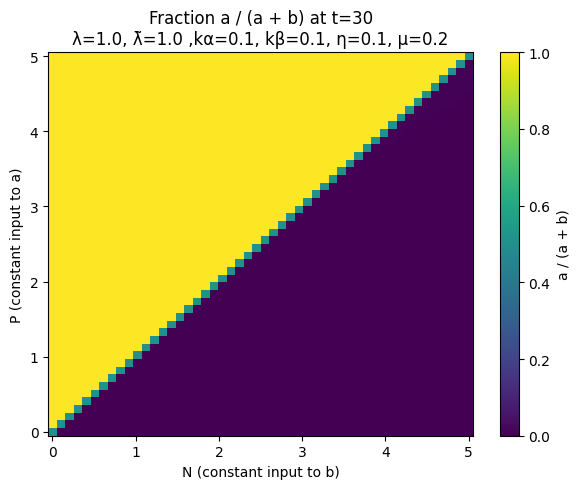

In [39]:
# === Plot the fraction heatmap with N on X-axis and P on Y-axis ===
plt.figure(figsize=(6, 5))

# Transpose frac to match axes (P on Y, N on X)
pcm = plt.pcolormesh(N_vals, P_vals, frac.T, cmap='viridis', shading='auto')

plt.xlabel('N (constant input to b)')     # X-axis
plt.ylabel('P (constant input to a)')     # Y-axis
plt.title(
    f'Fraction a / (a + b) at t={T_final}\n'
    f'λ={lambda_a}, λ̃={lambda_b} ,kα={k_alpha}, kβ={k_beta}, η={eta}, μ={mu}'
)

cbar = plt.colorbar(pcm)
cbar.set_label('a / (a + b)')

plt.tight_layout()
plt.show()



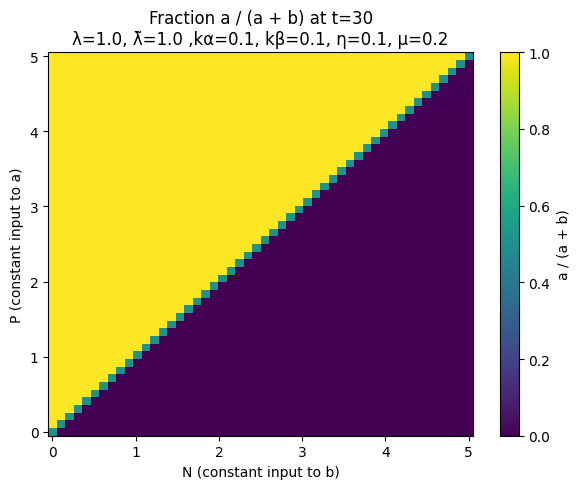